# AISC2007 DL Assignment2 Group 5

#### Importing Necessary Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix


In [3]:
# Directory containing images
image_folder = "C:/Users/singh/Downloads/yelp_dataset/photos"

In [4]:
#Directory containing imaage metadata
photos_df=pd.read_json("C:/Users/singh/Downloads/yelp_dataset/photos.json", lines=True)

In [5]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [6]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [7]:
photos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [8]:
photos_df['label'].isnull().sum()

0

In [9]:
# Count the number of occurrences of each label
label_counts = photos_df['label'].value_counts()
label_counts

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [10]:
# Sort the counts in descending order (high to low)
sorted_label_counts = label_counts.sort_values(ascending=False)

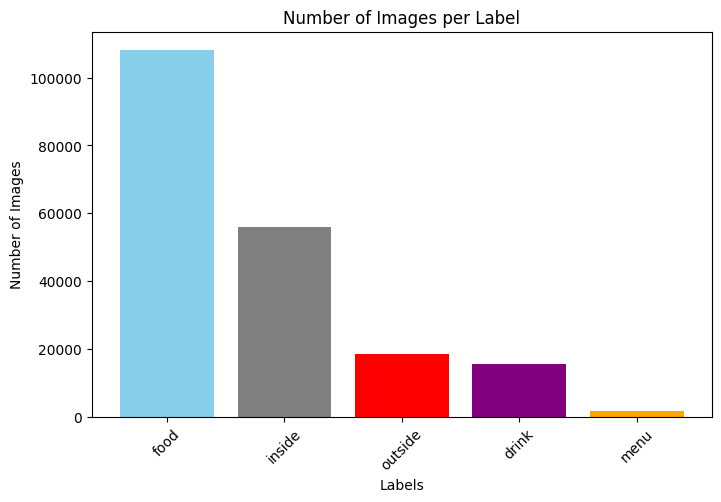

In [11]:
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(sorted_label_counts.index, sorted_label_counts.values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()


In [12]:
def load_images_with_metadata(photo_df, image_folder, max_images_per_label=1678):
    images, labels = [], []
    label_counts = {}  # Dictionary to keep track of loaded images per label

    for index, row in photo_df.iterrows():
        photo_id = row['photo_id']
        label = row['label']

        # Initialize count for the label if it hasn't been already
        if label not in label_counts:
            label_counts[label] = 0

        # Check if the limit has been reached for this label
        if label_counts[label] >= max_images_per_label:
            continue  # Skip loading images for this label if limit is reached

        img_path = os.path.join(image_folder, f"{photo_id}.jpg")  # Adjust extension if needed

        try:
            # Load the image
            img = load_img(img_path, target_size=(128, 128))  # Adjust target size if needed
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            
            # Append the image and its corresponding label
            images.append(img_array)
            labels.append(label)

            # Increment the count for this label
            label_counts[label] += 1

        except FileNotFoundError:
            print(f"Image {img_path} not found.")
        except UnidentifiedImageError:
            print(f"Skipping {img_path}, not a valid image file.")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [13]:
X, y = load_images_with_metadata(photos_df, image_folder)

# Check the shape of the loaded data
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {len(y)} labels.")


Skipping C:/Users/singh/Downloads/yelp_dataset/photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg, not a valid image file.
Loaded 8390 images with shape (128, 128, 3) and 8390 labels.


# Preprocessing

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


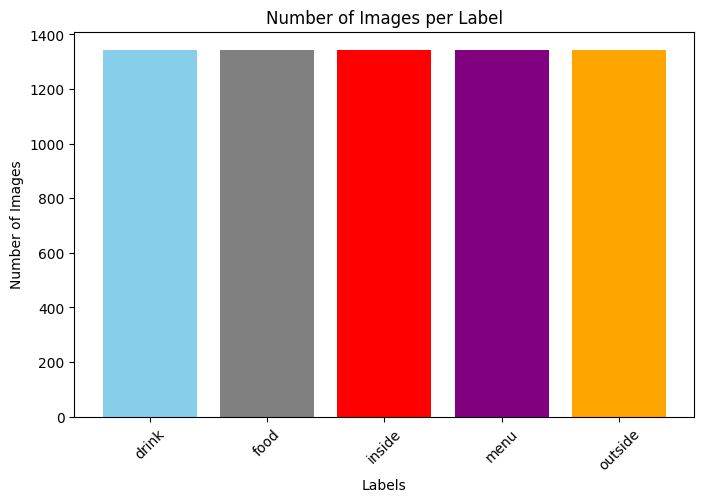

In [15]:
# Count the occurrences of each label
unique, counts = np.unique(y_train, return_counts=True)
sample_label_counts = dict(zip(unique, counts))

# Prepare data for plotting
labels = list(sample_label_counts.keys())
values = list(sample_label_counts.values())

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()


In [78]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode_labels(y):
    y_reshaped = y.reshape(-1, 1)  # Reshape for the encoder
    # Initialize OneHotEncoder with sparse_output
    one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
    # Fit and transform the labels
    y_onehot = one_hot_encoder.fit_transform(y_reshaped)
    return y_onehot

# Example usage:
y_train_onehot = one_hot_encode_labels(y_train)
y_test_onehot = one_hot_encode_labels(y_test)


In [79]:
counts=np.unique(y_train, return_counts=True)
counts

(array([0, 1, 2, 3, 4], dtype=int64),
 array([1342, 1343, 1342, 1342, 1343], dtype=int64))

In [80]:
X_train.shape

(6712, 128, 128, 3)

In [81]:
y_train.shape

(6712,)

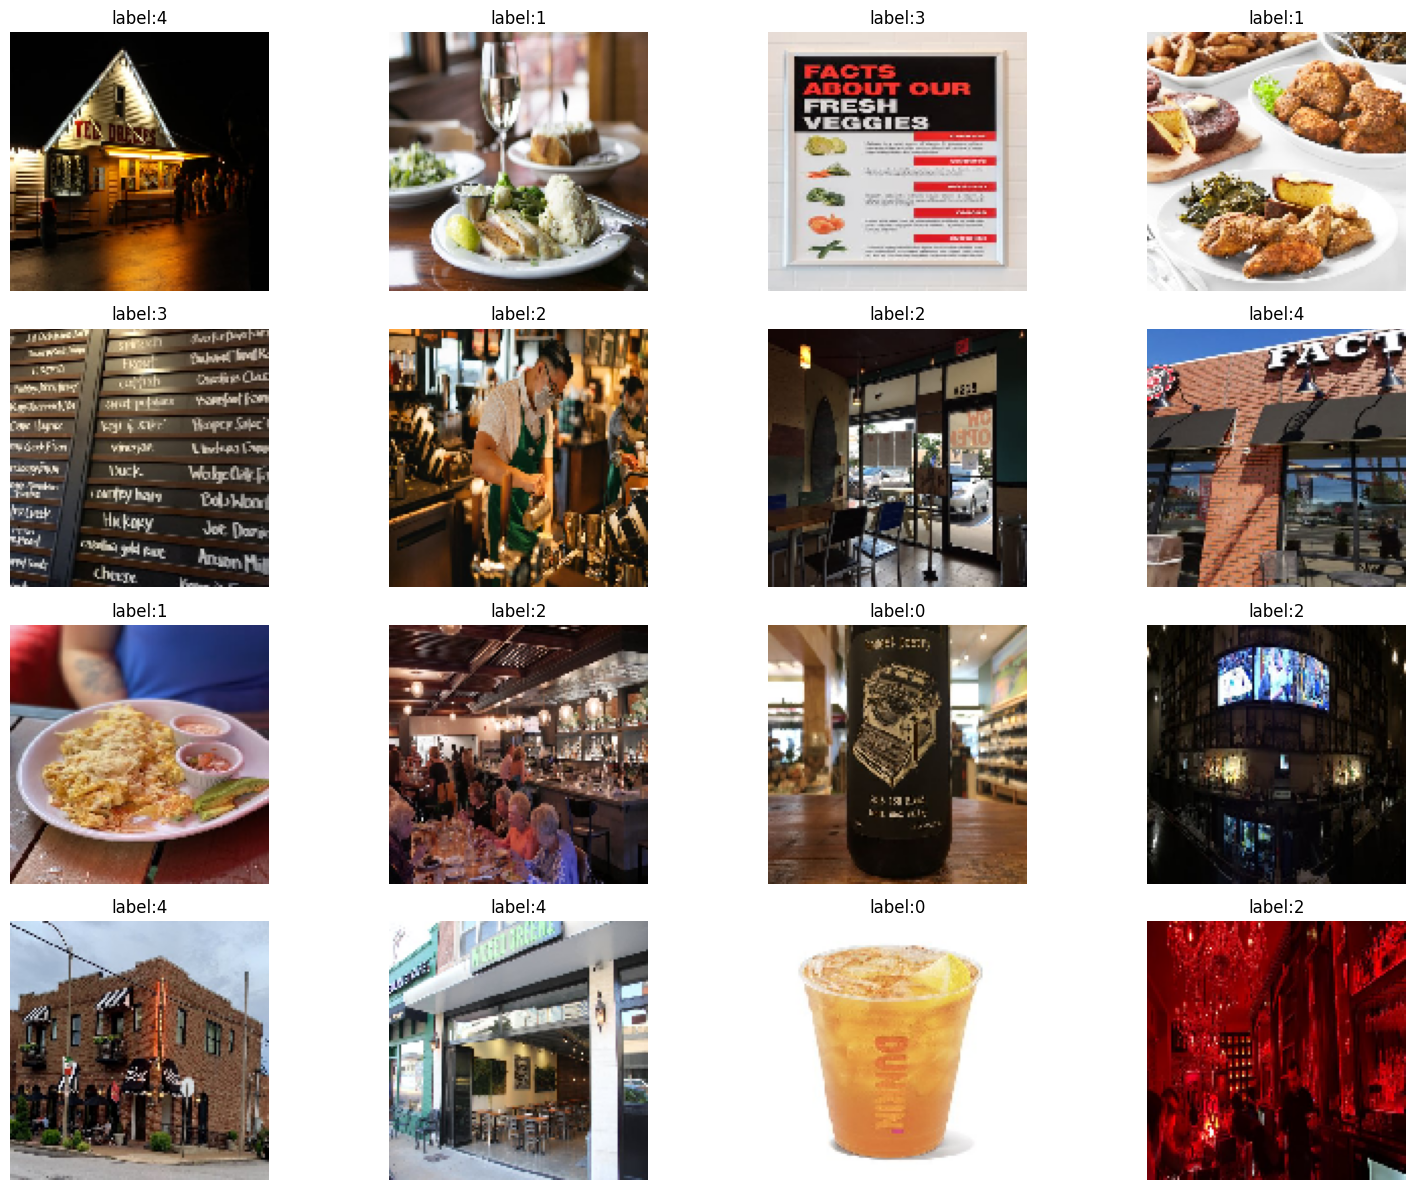

In [82]:
# Set the number of images to display (e.g., 9 images in a 3x3 grid)
num_images = 16
plt.figure(figsize=(16, 12))

# Loop through the number of images and plot each one
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])  # Show the image
    plt.title(f'label:{y_train[i]}')  # Show the class label
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### CNN Model

Class Balancing (Improved)

In [83]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [87]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Define your model architecture
model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Set learning rate and optimizer
learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with KL divergence
# Compile the model with categorical crossentropy
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
              metrics=['accuracy'])


# View the model summary
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,700,165 (6.49 MB)

 Trainable params: 1,699,717 (6.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
# Your model definition code here...

# Define best parameters
best_params = {
    'batch_size': 32,
    'epochs': 20,
    'dropout_rate': 0.2,
    'optimizer': 'adam'
}

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_test, y_test_onehot),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 46s 211ms/step - accuracy: 0.2849 - loss: 2.2809 - val_accuracy: 0.2139 - val_loss: 2.3426
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.4736 - loss: 1.3150 - val_accuracy: 0.3254 - val_loss: 1.7102
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.5229 - loss: 1.1995 - val_accuracy: 0.5810 - val_loss: 1.0756
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - accuracy: 0.5730 - loss: 1.0743 - val_accuracy: 0.6222 - val_loss: 0.9860
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.6228 - loss: 0.9918 - val_accuracy: 0.6263 - val_loss: 0.9499
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.6352 - loss: 0.9262 - val_accuracy: 0.6502 - val_loss: 0.9142
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.6640 - loss: 0.8755 - val_accuracy: 0.6567 - val_loss: 0.9034
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.6806 - loss: 0